# Libraries :

In [659]:
import numpy as np
from pandas import read_excel
import pandas as pd 
from sklearn.preprocessing import StandardScaler 
import datetime as dt
from tensorflow import keras
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import  KMeans
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
import tensorflow as tf
from tensorflow.keras import layers, models 
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate, Dropout, BatchNormalization
from tensorflow.keras.models import Model


# Data Preprocessing :

In [660]:
data = pd.read_excel("Online Retail.xlsx")

In [661]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [662]:
data.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,541909.000000,541909,541909.000000,406829.000000
mean,9.552250,2011-07-04 13:34:57.156386048,4.611114,15287.690570
min,-80995.000000,2010-12-01 08:26:00,-11062.060000,12346.000000
25%,1.000000,2011-03-28 11:34:00,1.250000,13953.000000
50%,3.000000,2011-07-19 17:17:00,2.080000,15152.000000
75%,10.000000,2011-10-19 11:27:00,4.130000,16791.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,218.081158,NaN,96.759853,1713.600303


In [663]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [664]:
data.isnull().sum().sort_values(ascending=False)

CustomerID     135080
Description      1454
StockCode           0
InvoiceNo           0
Quantity            0
InvoiceDate         0
UnitPrice           0
Country             0
dtype: int64

## remove cancelled orders (negative quantities, InvoiceNo starting with 'C')

In [665]:
data = data[( data["Quantity"]  > 0 ) & (~data["InvoiceNo"].astype(str).str.startswith("C") )]
data = data[data['UnitPrice'] > 0]

In [666]:
data.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,530104.000000,530104,530104.000000,397884.000000
mean,10.542037,2011-07-04 20:16:05.225087744,3.907625,15294.423453
min,1.000000,2010-12-01 08:26:00,0.001000,12346.000000
25%,1.000000,2011-03-28 12:22:00,1.250000,13969.000000
50%,3.000000,2011-07-20 12:58:00,2.080000,15159.000000
75%,10.000000,2011-10-19 12:39:00,4.130000,16795.000000
max,80995.000000,2011-12-09 12:50:00,13541.330000,18287.000000
std,155.524124,NaN,35.915681,1713.141560


## Handle missing CustomerIDs (approximately 135,000 records) 

In [667]:
data = data.dropna(subset=['CustomerID'])
data['Description'] = data['Description'].fillna('unknown')

In [668]:
data.isnull().sum().sort_values(ascending=False)

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

## Calculate Customer Lifetime Value: Total spending per customer (Quantity × UnitPrice)

In [669]:
data['customer lifetime value'] = data['Quantity'] * data['UnitPrice']

## duplicates handled

In [670]:
data.duplicated().sum()

np.int64(5192)

In [671]:
data = data.drop_duplicates()

In [672]:
data.duplicated().sum()

np.int64(0)

## removed outliers

In [673]:
Q1 = data['Quantity'].quantile(0.25)
Q3 = data['Quantity'].quantile(0.75)
IQR = Q3 - Q1
data = data[~((data['Quantity'] < (Q1 - 1.5 * IQR)) | (data['Quantity'] > (Q3 + 1.5 * IQR)))]

In [674]:
Q1 = data['UnitPrice'].quantile(0.25)
Q3 = data['UnitPrice'].quantile(0.75)
IQR = Q3 - Q1
data = data[~((data['UnitPrice'] < (Q1 - 1.5 * IQR)) | (data['UnitPrice'] > (Q3 + 1.5 * IQR)))]

# Create RFM features:

In [675]:
data['Total'] = data['Quantity'] * data['UnitPrice']

refDate = data['InvoiceDate'].max() + dt.timedelta(days=1)

lastDate = data.groupby('CustomerID')['InvoiceDate'].max()
recency = (refDate - lastDate).dt.days

frequency = data.groupby('CustomerID')['InvoiceNo'].nunique()
monetary = data.groupby('CustomerID')['Total'].sum()

rfm = pd.DataFrame({'Recency': recency, 'Frequency': frequency, 'Monetary': monetary})

data = data.merge(rfm, on='CustomerID', how='left')

### Engineer temporal features

In [676]:
data['hour'] = data['InvoiceDate'].dt.hour
data['dayofweek'] = data['InvoiceDate'].dt.dayofweek
data['month'] = data['InvoiceDate'].dt.month

### season from InvoiceDate

In [677]:
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'
data['season'] = data['month'].apply(get_season)

### Handle categorical variables
  - Country and season

In [678]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 333234 entries, 0 to 333233
Data columns (total 17 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   InvoiceNo                333234 non-null  object        
 1   StockCode                333234 non-null  object        
 2   Description              333234 non-null  object        
 3   Quantity                 333234 non-null  int64         
 4   InvoiceDate              333234 non-null  datetime64[ns]
 5   UnitPrice                333234 non-null  float64       
 6   CustomerID               333234 non-null  float64       
 7   Country                  333234 non-null  object        
 8   customer lifetime value  333234 non-null  float64       
 9   Total                    333234 non-null  float64       
 10  Recency                  333234 non-null  int64         
 11  Frequency                333234 non-null  int64         
 12  Monetary        

In [679]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,customer lifetime value,Total,Recency,Frequency,Monetary,hour,dayofweek,month,season
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,15.30,372,34,4462.16,8,2,12,Winter
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,20.34,372,34,4462.16,8,2,12,Winter
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,22.00,372,34,4462.16,8,2,12,Winter
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,20.34,372,34,4462.16,8,2,12,Winter
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,20.34,372,34,4462.16,8,2,12,Winter


In [680]:
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
ohe_features = ohe.fit_transform(data[['Country', 'season']])


ohe_df = pd.DataFrame(ohe_features, columns=ohe.get_feature_names_out(['Country', 'season']))
data = pd.concat([data.reset_index(drop=True), ohe_df.reset_index(drop=True)], axis=1)
data.drop(columns=['Country', 'season'], inplace=True)
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,customer lifetime value,Total,Recency,...,Country_Sweden,Country_Switzerland,Country_USA,Country_United Arab Emirates,Country_United Kingdom,Country_Unspecified,season_Fall,season_Spring,season_Summer,season_Winter
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,15.30,15.30,372,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,20.34,20.34,372,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,22.00,22.00,372,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,20.34,20.34,372,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,20.34,20.34,372,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


### Handle categorical variables
 - product categories from Description

In [681]:
keyWords = '(CANDLE|BAG|MUG|HANGER|TOY|CUP|CHRISTMAS|PARTY|STICKER)'

data['Category'] = data['Description'].str.upper().str.extract(keyWords, expand=False)
data['Category'] = data['Category'].fillna('OTHER')

In [682]:
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
ohe_features = ohe.fit_transform(data[['Category']])


ohe_df = pd.DataFrame(ohe_features, columns=ohe.get_feature_names_out(['Category']))
data = pd.concat([data.reset_index(drop=True), ohe_df.reset_index(drop=True)], axis=1)
data.drop(columns=['Category'], inplace=True)
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,customer lifetime value,Total,Recency,...,Category_BAG,Category_CANDLE,Category_CHRISTMAS,Category_CUP,Category_HANGER,Category_MUG,Category_OTHER,Category_PARTY,Category_STICKER,Category_TOY
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,15.30,15.30,372,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,20.34,20.34,372,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,22.00,22.00,372,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,20.34,20.34,372,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,20.34,20.34,372,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


##  Normalize numerical features using StandardScaler 

In [683]:
dataEda = data.copy()

In [684]:
numeric_features = ['Quantity', 'UnitPrice', 'Total', 'hour', 'dayofweek', 'month','Recency', 'Frequency', 'Monetary']

scaler = StandardScaler()
numeric_features_scaled = scaler.fit_transform(data[numeric_features])
data[numeric_features] = numeric_features_scaled

In [685]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,customer lifetime value,Total,Recency,...,Category_BAG,Category_CANDLE,Category_CHRISTMAS,Category_CUP,Category_HANGER,Category_MUG,Category_OTHER,Category_PARTY,Category_STICKER,Category_TOY
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,-0.228808,2010-12-01 08:26:00,0.230129,17850.0,15.30,0.181440,4.996809,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,536365,71053,WHITE METAL LANTERN,-0.228808,2010-12-01 08:26:00,0.773462,17850.0,20.34,0.562827,4.996809,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,0.066298,2010-12-01 08:26:00,0.359494,17850.0,22.00,0.688442,4.996809,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,-0.228808,2010-12-01 08:26:00,0.773462,17850.0,20.34,0.562827,4.996809,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,-0.228808,2010-12-01 08:26:00,0.773462,17850.0,20.34,0.562827,4.996809,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


# Exploratory Data Analysis

    - USE dataEda for the Exploratory

In [686]:
dataEda.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,customer lifetime value,Total,Recency,...,Category_BAG,Category_CANDLE,Category_CHRISTMAS,Category_CUP,Category_HANGER,Category_MUG,Category_OTHER,Category_PARTY,Category_STICKER,Category_TOY
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,15.30,15.30,372,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,20.34,20.34,372,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,22.00,22.00,372,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,20.34,20.34,372,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,20.34,20.34,372,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


# Customer distribution analysis by country (UK-focused business)

In [687]:
country_cols = [col for col in dataEda.columns if col.startswith("Country_")]

dataEda[country_cols] = dataEda[country_cols].apply(pd.to_numeric, errors='coerce')

dataEda['Country_reconstructed'] = (
    dataEda[country_cols]
    .idxmax(axis=1)
    .str.replace("Country_", "")
)

In [688]:
unique_customers_by_country = dataEda.groupby('Country_reconstructed')['CustomerID'].nunique().sort_values(ascending=False)

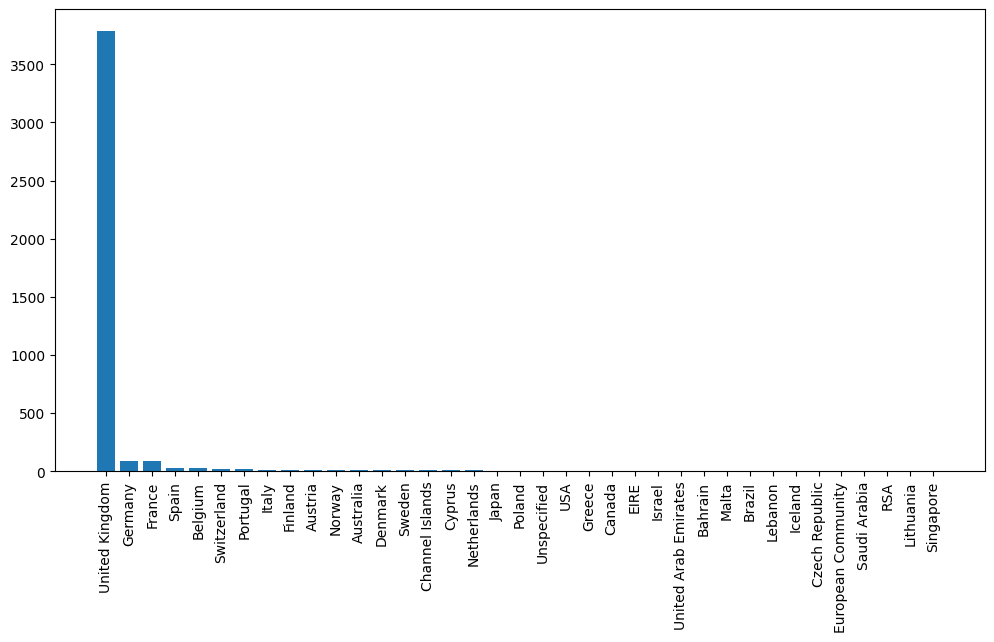

In [689]:
plt.figure(figsize=(12,6))
plt.bar(unique_customers_by_country.index, unique_customers_by_country.values)
plt.xticks(rotation=90)
plt.show()

# Time-series analysis of sales trends across 2010-2011 

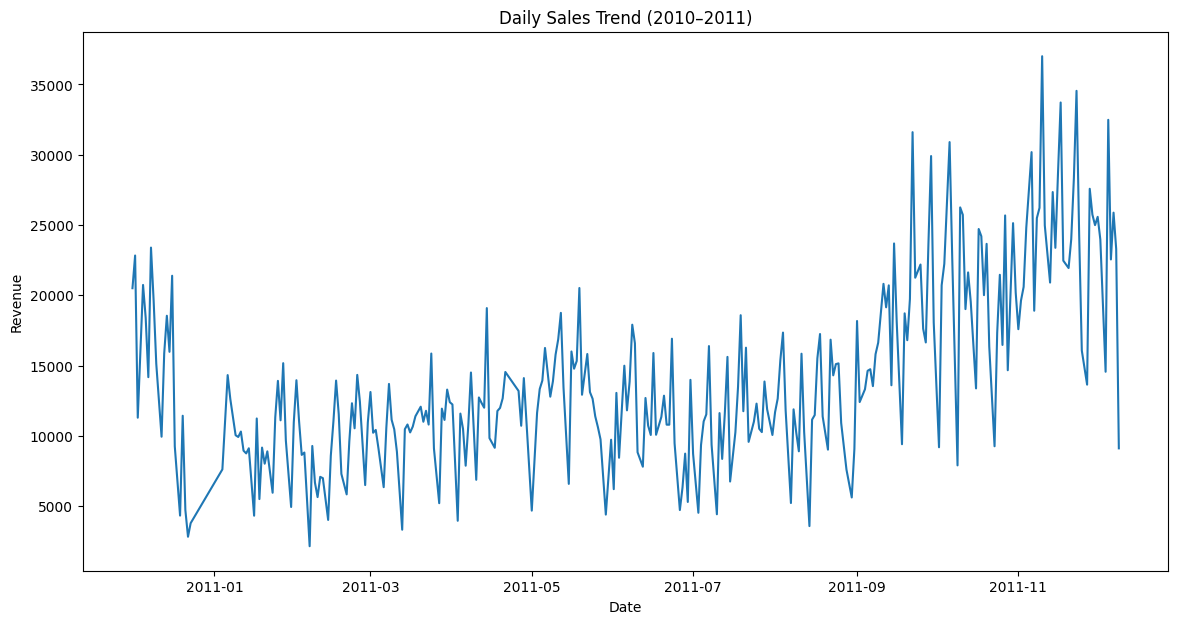

In [690]:
sales = dataEda.groupby(dataEda['InvoiceDate'].dt.date)['Total'].sum()

plt.figure(figsize=(14,7))
plt.plot(sales.index, sales.values)
plt.title("Daily Sales Trend (2010–2011)")
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.show()

# Customer lifetime value distribution and Pareto analysis (80/20 rule) 

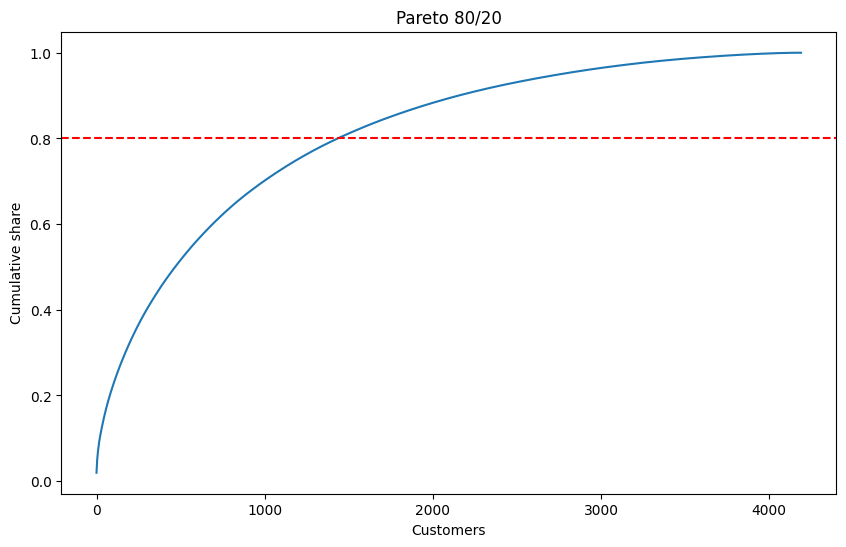

In [691]:
CLV = dataEda.groupby('CustomerID')['Total'].sum()

CLV_sorted = CLV.sort_values(ascending=False).reset_index(drop=True)

CUMP = CLV_sorted.cumsum() / CLV_sorted.sum()

plt.figure(figsize=(10,6))
plt.plot(CUMP.index, CUMP.values)
plt.axhline(y=0.8, color='r', linestyle='--')
plt.title('Pareto 80/20')
plt.xlabel('Customers')
plt.ylabel('Cumulative share')
plt.show()

# RFM feature distributions and correlations

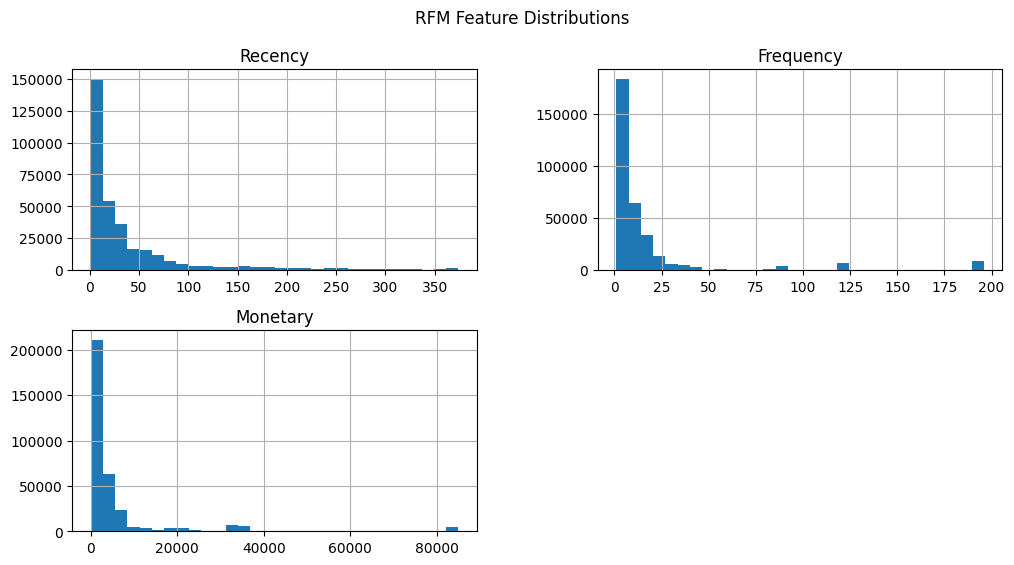

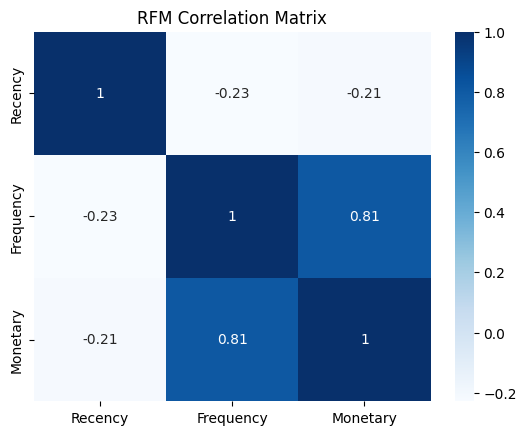

In [692]:
dataEda[['Recency', 'Frequency', 'Monetary']].hist(bins=30, figsize=(12,6))
plt.suptitle("RFM Feature Distributions")
plt.show()
sns.heatmap(dataEda[['Recency','Frequency','Monetary']].corr(), annot=True, cmap='Blues')
plt.title("RFM Correlation Matrix")
plt.show()

# Product popularity analysis using StockCode and Description 

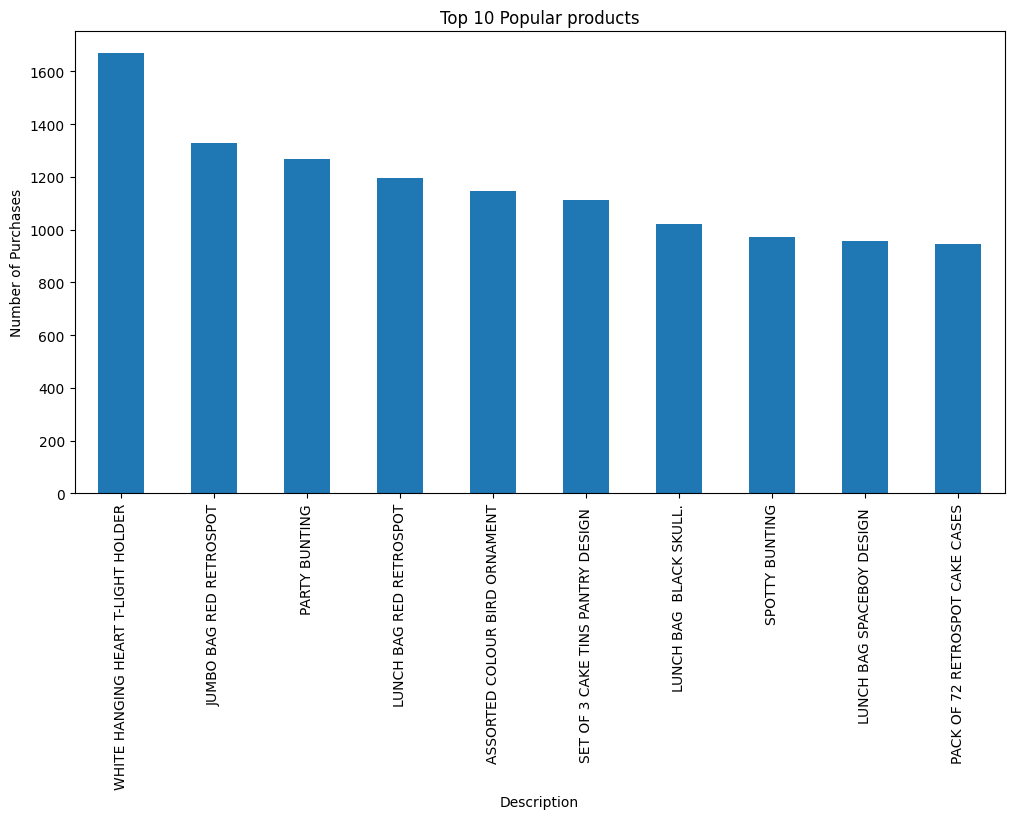

In [693]:
pop_products = dataEda['Description'].value_counts().head(10)
pop_products.plot(kind='bar', figsize=(12,6), title='Top 10 Popular products')
plt.xlabel('Description')
plt.ylabel('Number of Purchases')
plt.show()

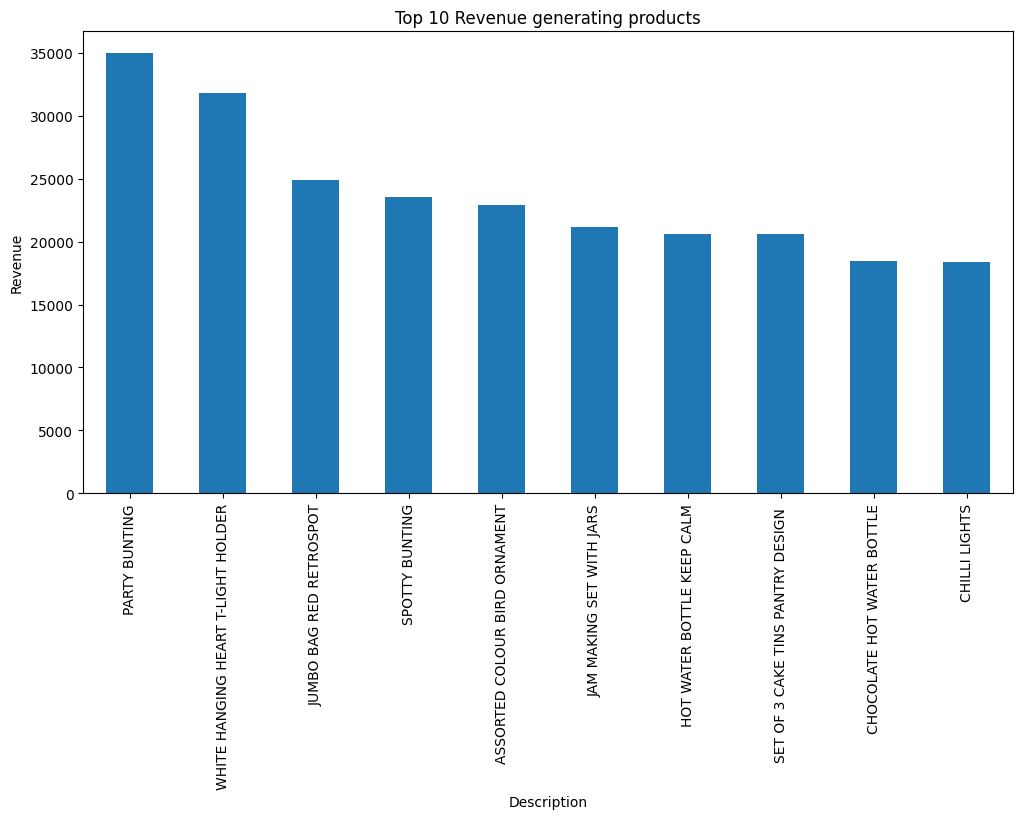

In [694]:
pop_revenue = dataEda.groupby('Description')['Total'].sum().sort_values(ascending=False).head(10)
pop_revenue.plot(kind='bar', figsize=(12,6), title='Top 10 Revenue generating products')
plt.xlabel('Description')
plt.ylabel('Revenue')
plt.show()

# Cohort analysis to track customer retention over time 

In [695]:
dataEda['InvoiceMonth'] = dataEda['InvoiceDate'].dt.to_period('M')
dataEda['CohortMonth'] = dataEda.groupby('CustomerID')['InvoiceMonth'].transform('min')

In [696]:
dataEda['CohortIndex'] = (dataEda['InvoiceMonth'] - dataEda['CohortMonth']).apply(lambda x: x.n)
cohort = dataEda.groupby(['CohortMonth', 'CohortIndex'])['CustomerID'].nunique().reset_index()
cohort_pivot = cohort.pivot(index='CohortMonth', columns='CohortIndex', values='CustomerID')

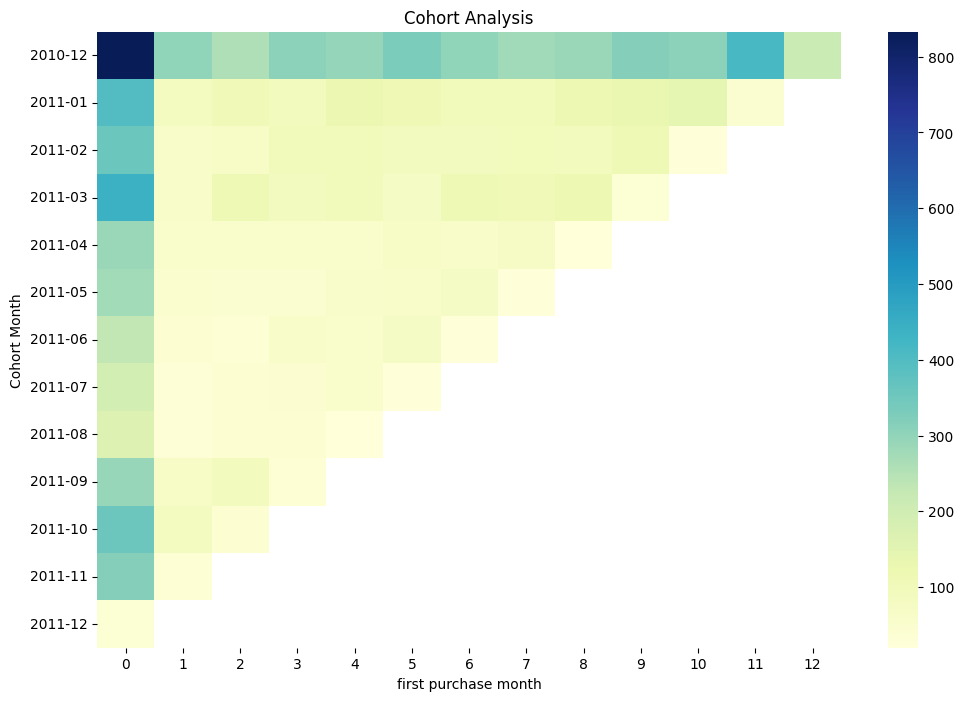

In [697]:
plt.figure(figsize=(12,8))
sns.heatmap(cohort_pivot, annot=False, cmap='YlGnBu')
plt.title('Cohort Analysis')
plt.xlabel('first purchase month')
plt.ylabel('Cohort Month')
plt.show()

# Seasonal patterns and peak purchasing periods 

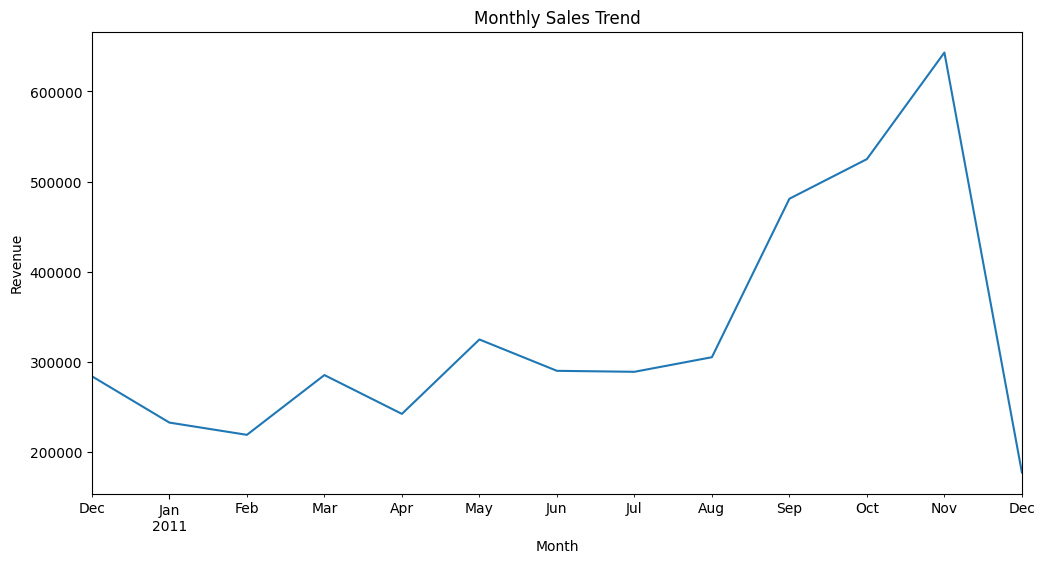

In [698]:
mon_sales = dataEda.groupby(dataEda['InvoiceDate'].dt.to_period('M'))['Total'].sum()
mon_sales.plot(figsize=(12,6), title='Monthly Sales Trend')
plt.xlabel('Month')
plt.ylabel('Revenue')
plt.show()

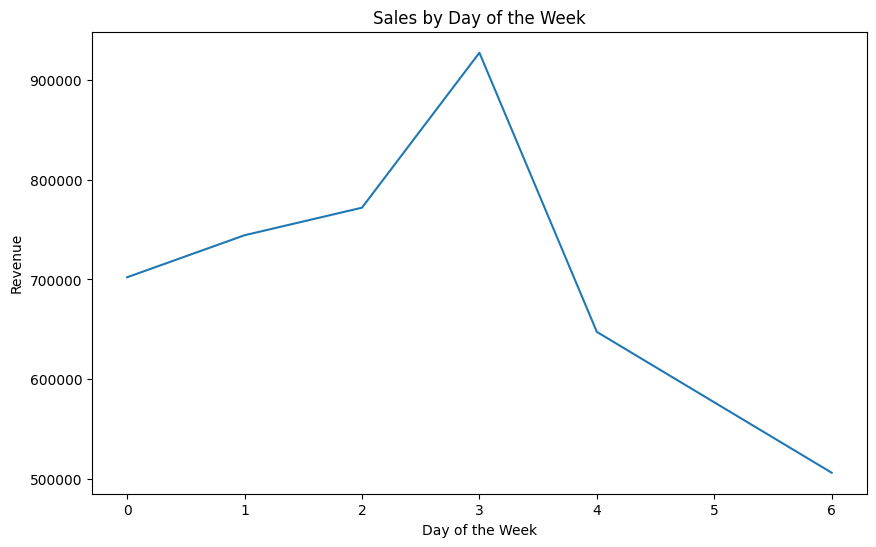

In [699]:
dow_sales = dataEda.groupby('dayofweek')['Total'].sum()
dow_sales.plot( figsize=(10,6), title='Sales by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Revenue')
plt.show()

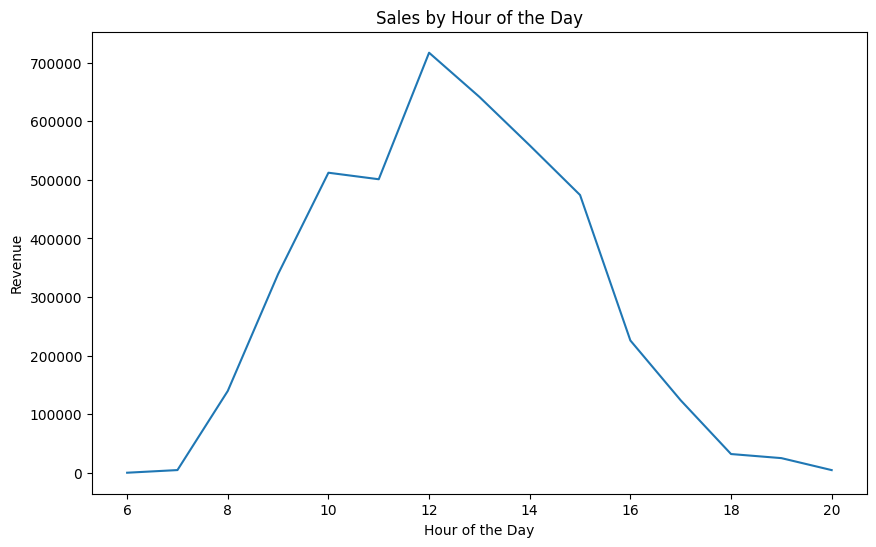

In [700]:
hour_sales = dataEda.groupby('hour')['Total'].sum()
hour_sales.plot(figsize=(10,6), title='Sales by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Revenue')
plt.show()

# Geographic analysis of customer spending patterns

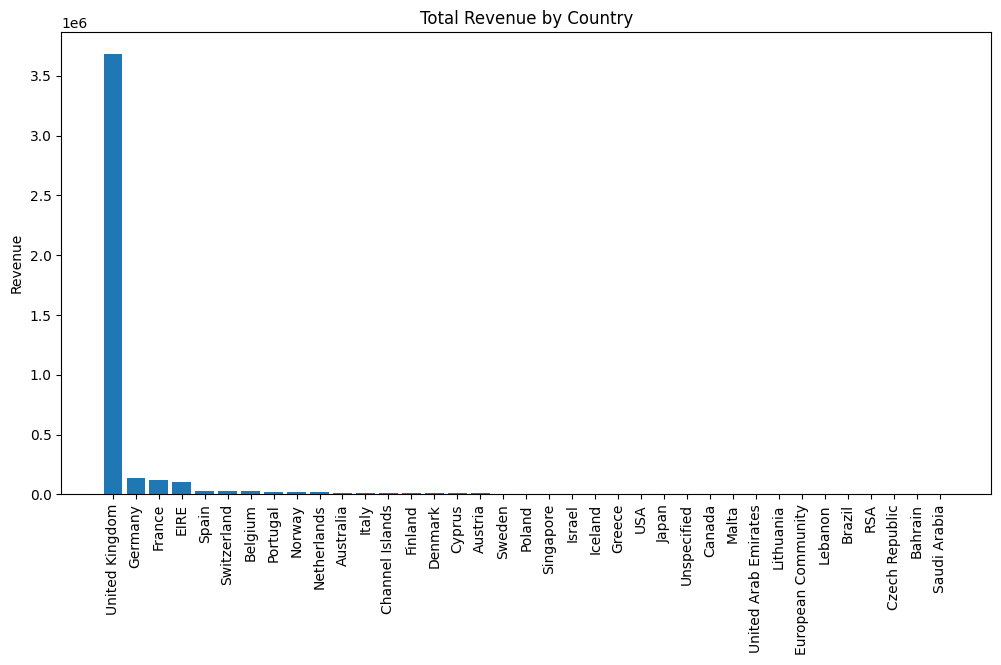

In [701]:
country_rev = dataEda.groupby('Country_reconstructed')['Total'].sum().sort_values(ascending=False)

plt.figure(figsize=(12,6))
plt.bar(country_rev.index, country_rev.values)
plt.xticks(rotation=90)
plt.title('Total Revenue by Country')
plt.ylabel('Revenue')
plt.show()

# UNSUPERVISED ML

> K-Means

In [702]:
x = data[["Recency", "Frequency"]]

In [703]:
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

In [704]:
wcss = []
k_range = range(1, 10)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(x_scaled)
    wcss.append(kmeans.inertia_)

In [705]:
wcss

[666467.9999999854,
 377346.7298361575,
 132490.6752801192,
 91186.57094809183,
 59766.58069558646,
 39166.870574408065,
 28872.817050683545,
 25609.53760676034,
 20515.381343219542]

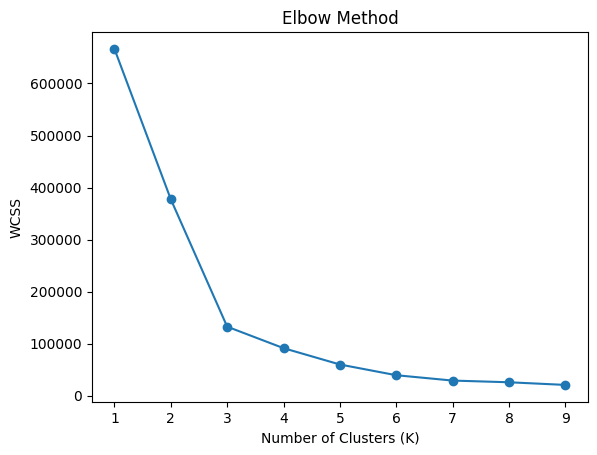

In [706]:
plt.plot(k_range, wcss, marker='o')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("WCSS")
plt.title("Elbow Method")
plt.show()

In [707]:
best_model = KMeans(n_clusters=3)
best_model.fit(x_scaled)
y_pred = best_model.predict(x_scaled)

In [708]:
y_pred

array([1, 1, 1, ..., 0, 0, 0], shape=(333234,), dtype=int32)

In [709]:
x_scaled_df = pd.DataFrame(x_scaled)
x_scaled_df['cluster'] = y_pred

data['kmean']= y_pred

In [710]:
best_model.cluster_centers_

array([[-0.25785845, -0.22302662],
       [ 2.6480132 , -0.41366318],
       [-0.60877043,  3.46742025]])

>GaussianMixture

In [711]:
x = data[["Recency", "Frequency"]]
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

In [712]:
bic_scores = []
n_components_range = range(1, 10)
for n in n_components_range:
    gmm = GaussianMixture(n_components=n, random_state=42)
    gmm.fit(x_scaled)
    bic_scores.append(gmm.bic(x_scaled))

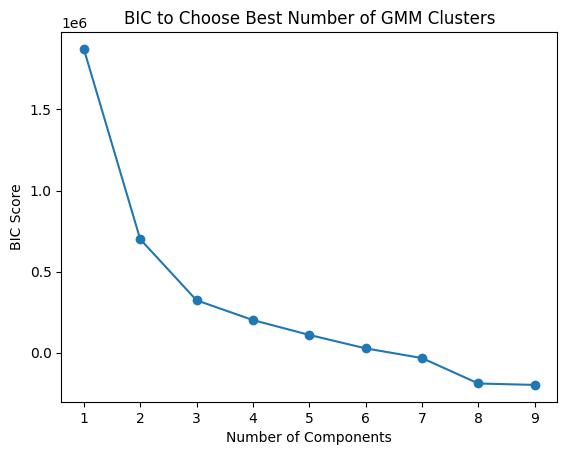

In [713]:
plt.plot(n_components_range, bic_scores, marker='o')
plt.xlabel("Number of Components")
plt.ylabel("BIC Score")
plt.title("BIC to Choose Best Number of GMM Clusters")
plt.show()

In [714]:
gmm = GaussianMixture(n_components=3, random_state=42)
gmm_labels = gmm.fit_predict(x_scaled)

In [715]:
data["GMM"] = gmm_labels
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,customer lifetime value,Total,Recency,...,Category_CHRISTMAS,Category_CUP,Category_HANGER,Category_MUG,Category_OTHER,Category_PARTY,Category_STICKER,Category_TOY,kmean,GMM
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,-0.228808,2010-12-01 08:26:00,0.230129,17850.0,15.30,0.181440,4.996809,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,2
1,536365,71053,WHITE METAL LANTERN,-0.228808,2010-12-01 08:26:00,0.773462,17850.0,20.34,0.562827,4.996809,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,2
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,0.066298,2010-12-01 08:26:00,0.359494,17850.0,22.00,0.688442,4.996809,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,2
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,-0.228808,2010-12-01 08:26:00,0.773462,17850.0,20.34,0.562827,4.996809,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,2
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,-0.228808,2010-12-01 08:26:00,0.773462,17850.0,20.34,0.562827,4.996809,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,2


>PCA


In [716]:
pca = PCA(n_components=2)
pca_data = pca.fit_transform(x_scaled)
data["PCA1"] = pca_data[:, 0]
data["PCA2"] = pca_data[:, 1]

Explained variance ratio: [0.61431481 0.38568519]


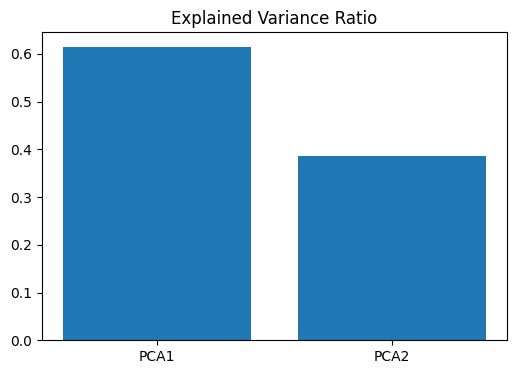

In [717]:
print("Explained variance ratio:", pca.explained_variance_ratio_)
plt.figure(figsize=(6,4))
plt.bar(["PCA1", "PCA2"], pca.explained_variance_ratio_)
plt.title("Explained Variance Ratio")
plt.show()

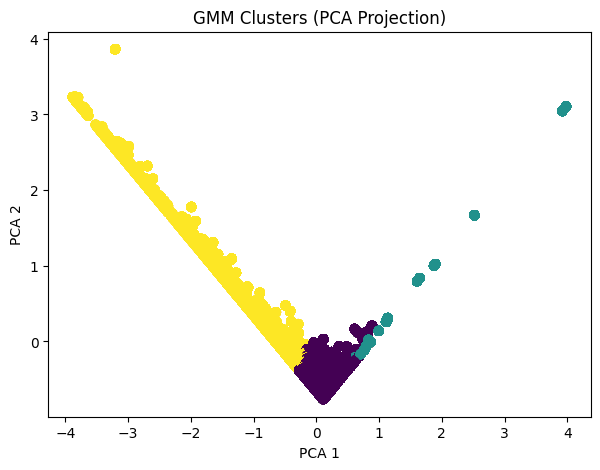

In [718]:
plt.figure(figsize=(7,5))
plt.scatter(data["PCA1"], data["PCA2"], c=data["GMM"], s=40)
plt.title("GMM Clusters (PCA Projection)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()

# Supervised ML
• Implement Linear Regression with RFM features as baseline

In [719]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 333234 entries, 0 to 333233
Data columns (total 70 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   InvoiceNo                     333234 non-null  object        
 1   StockCode                     333234 non-null  object        
 2   Description                   333234 non-null  object        
 3   Quantity                      333234 non-null  float64       
 4   InvoiceDate                   333234 non-null  datetime64[ns]
 5   UnitPrice                     333234 non-null  float64       
 6   CustomerID                    333234 non-null  float64       
 7   customer lifetime value       333234 non-null  float64       
 8   Total                         333234 non-null  float64       
 9   Recency                       333234 non-null  float64       
 10  Frequency                     333234 non-null  float64       
 11  Monetary     

In [ ]:
x = data.drop(columns=['Monetary', 'InvoiceNo', 'StockCode', 'Description', 'InvoiceDate', 'CustomerID', 'Total','customer lifetime value'])
y = data['Monetary']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

Linear_model = LinearRegression()
Linear_model.fit(x_train, y_train) 

Linear_y_pred = Linear_model.predict(x_test)

• Build Random Forest regressor with 200 estimators for non-linear relationships

In [ ]:
rf_model = RandomForestRegressor(n_estimators=200, random_state=42,n_jobs=-1)
rf_model.fit(x_train, y_train)

rf_y_pred = rf_model.predict(x_test)

• Train XGBoost with hyperparameter tuning for optimal performance

In [ ]:
Xgb_model = XGBRegressor(n_estimators=200, learning_rate=0.1, random_state=42)
Xgb_model.fit(x_train, y_train)

Xgb_y_pred = Xgb_model.predict(x_test)

• Evaluate models using RMSE, MAE, and R-squared metrics


> linear Regression

In [ ]:
Linear_MSE = mean_squared_error(y_test, Linear_y_pred)
Linear_Rmse = np.sqrt(Linear_MSE)

Linear_MAE = mean_absolute_error(y_test, Linear_y_pred)

Linear_R2_score = r2_score(y_test, Linear_y_pred)

print(f"Linear Regression - RMSE: {Linear_Rmse:.4f}, MAE: {Linear_MAE:.4f}, R2 Score: {Linear_R2_score:.4f}")

Linear Regression - RMSE: 0.4467, MAE: 0.2161, R2 Score: 0.8005


> RandomforestRegressor 


In [ ]:
Rf_MSE = mean_squared_error(y_test, rf_y_pred)
Rf_Rmse = np.sqrt(Rf_MSE)

Rf_MAE = mean_absolute_error(y_test, rf_y_pred)

Rf_R2_score = r2_score(y_test, rf_y_pred)

print(f" RandomforestRegressor - RMSE: {Rf_Rmse:.4f}, MAE: {Rf_MAE:.4f}, R2 Score: {Rf_R2_score:.4f}")

 RandomforestRegressor - RMSE: 0.0309, MAE: 0.0043, R2 Score: 0.9990


> XGBoost

In [ ]:
Xgb_MSE = mean_squared_error(y_test, Xgb_y_pred)
Xgb_Rmse = np.sqrt(Xgb_MSE)

Xgb_MAE = mean_absolute_error(y_test, Xgb_y_pred)

Xgb_R2_score = r2_score(y_test, Xgb_y_pred)

print(f" Xgb - RMSE: {Xgb_Rmse:.4f}, MAE: {Xgb_MAE:.4f}, R2 Score: {Xgb_R2_score:.4f}")

 Xgb - RMSE: 0.0863, MAE: 0.0449, R2 Score: 0.9925


• Perform feature importance analysis to identify key value drivers

> RandomforestRegressor

In [ ]:
rf_importances = rf_model.feature_importances_
feature_names = x.columns

rf_importance_table = pd.DataFrame({'Feature': feature_names, 'Importance': rf_importances}).sort_values(by='Importance', ascending=False)
print(rf_importance_table) 

                         Feature    Importance
17                  Country_EIRE  5.254302e-01
3                      Frequency  1.815156e-01
60                          PCA1  1.679668e-01
2                        Recency  9.260886e-02
61                          PCA2  7.947416e-03
..                           ...           ...
41  Country_United Arab Emirates  4.962821e-08
28             Country_Lithuania  9.496299e-09
15        Country_Czech Republic  5.526418e-09
9                Country_Bahrain  2.406948e-09
35          Country_Saudi Arabia  8.262682e-10

[62 rows x 2 columns]


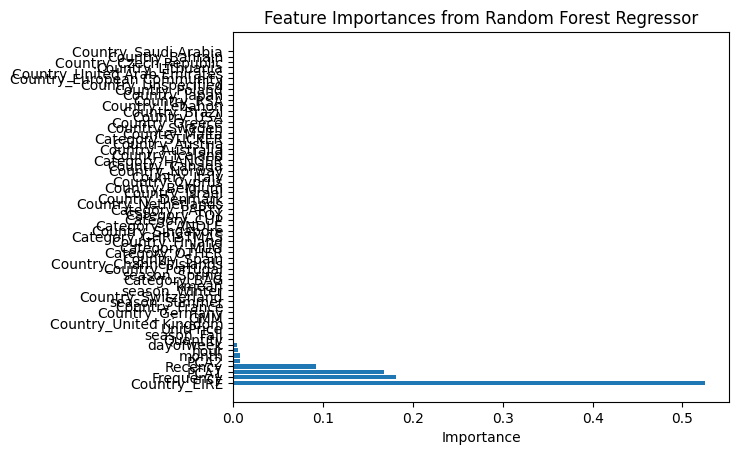

In [ ]:
plt.barh(rf_importance_table['Feature'], rf_importance_table['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importances from Random Forest Regressor')
plt.show()

> XGboost

In [ ]:
Xgb_importances = Xgb_model.feature_importances_
Xgb_importance_table = pd.DataFrame({'Feature': feature_names, 'Importance': Xgb_importances}).sort_values(by='Importance', ascending=False)
print(Xgb_importance_table)

                Feature  Importance
17         Country_EIRE    0.959365
3             Frequency    0.017389
2               Recency    0.006021
44          season_Fall    0.005049
60                 PCA1    0.004460
..                  ...         ...
34          Country_RSA    0.000000
43  Country_Unspecified    0.000000
55       Category_PARTY    0.000000
56     Category_STICKER    0.000000
58                kmean    0.000000

[62 rows x 2 columns]


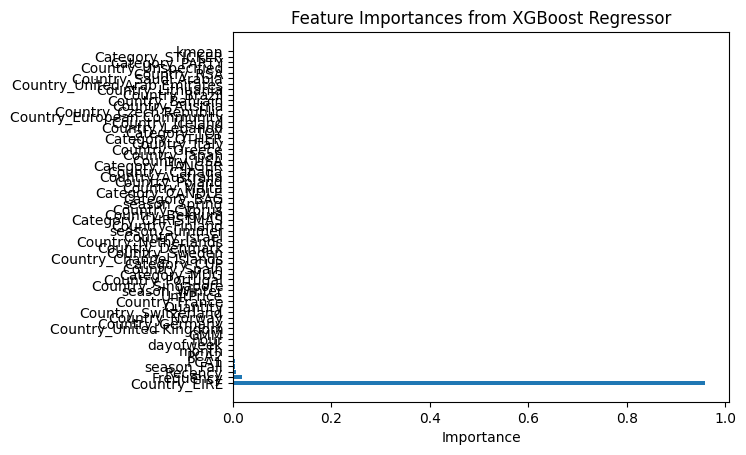

In [ ]:
plt.barh(Xgb_importance_table['Feature'], Xgb_importance_table['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importances from XGBoost Regressor')
plt.show()

• Use cross-validation to ensure model robustness and prevent overfitting



> Linear Regression

In [730]:
Linear_scores = cross_val_score(Linear_model, x, y, cv=5, scoring='r2')

print("Linear Regression R² scores:", Linear_scores)
print("Mean R²:", Linear_scores.mean())

Linear Regression R² scores: [0.73604222 0.87985031 0.83709141 0.77675411 0.70577696]
Mean R²: 0.7871030012386687


> RandomforestRegressor

In [731]:
rf_scores = cross_val_score(rf_model, x, y, cv=5, scoring='r2')

print("Random Forest R² scores:", rf_scores)
print("Mean R²:", rf_scores.mean())

Random Forest R² scores: [0.97943228 0.98874759 0.97493271 0.96688593 0.90158813]
Mean R²: 0.9623173266336963


> XGboost

In [732]:
Xgb_scores = cross_val_score(Xgb_model, x, y, cv=5, scoring='r2')

print("XGBoost R² scores:", Xgb_scores)
print("Mean R²:", Xgb_scores.mean())

XGBoost R² scores: [0.98006733 0.99159951 0.98673068 0.9792407  0.92619329]
Mean R²: 0.9727663038418658


• Compare model performance against business benchmarks

In [733]:
mean_value = y.mean()
y_pred_benchmark = [mean_value] * len(y)

In [734]:
Mse_benchmark = mean_squared_error(y, y_pred_benchmark)
R2_benchmark = r2_score(y, y_pred_benchmark)

In [ ]:
results = {
    "Model": ["Benchmark", "Linear Regression", "Random Forest", "XGBoost"],
    "R²": [R2_benchmark, Linear_R2_score, Rf_R2_score, Xgb_R2_score],
    "MSE": [Mse_benchmark, Linear_MSE, Rf_MSE, Xgb_MSE]
}

results_table = pd.DataFrame(results)
print(results_table)


print("\n"+("-"*50))
print("Models accuracy comparison:")
print(f"\nbenchmark accuracy: {R2_benchmark:.4f}%", f"\nLinear_Regression accuracy: {Linear_R2_score:4f}%", f"\nRandom_forest_Regressor accuracy: {Rf_R2_score:.4f}%", f"\nXGboost accuracy: {Xgb_R2_score:.4f}%")

               Model        R²       MSE
0          Benchmark  0.000000  1.000000
1  Linear Regression  0.800493  0.199564
2      Random Forest  0.999048  0.000952
3            XGBoost  0.992549  0.007454

--------------------------------------------------
Models accuracy comparison:

benchmark accuracy: 0.0000% 
Linear_Regression accuracy: 0.800493% 
Random_forest_Regressor accuracy: 0.9990% 
XGboost accuracy: 0.9925%


# ML models save

In [ ]:
import joblib
joblib.dump(Linear_model, 'linear_regression_model.pkl')
# joblib.dump(rf_model, 'random_forest_model.pkl', compress=9)
joblib.dump(Xgb_model, 'xgboost_model.pkl')

['xgboost_model.pkl']

# deep learning


### Baseline DNN

In [737]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 333234 entries, 0 to 333233
Data columns (total 70 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   InvoiceNo                     333234 non-null  object        
 1   StockCode                     333234 non-null  object        
 2   Description                   333234 non-null  object        
 3   Quantity                      333234 non-null  float64       
 4   InvoiceDate                   333234 non-null  datetime64[ns]
 5   UnitPrice                     333234 non-null  float64       
 6   CustomerID                    333234 non-null  float64       
 7   customer lifetime value       333234 non-null  float64       
 8   Total                         333234 non-null  float64       
 9   Recency                       333234 non-null  float64       
 10  Frequency                     333234 non-null  float64       
 11  Monetary     

In [738]:
dl_features = data.drop(columns=['Monetary', 'InvoiceNo', 'StockCode', 'Description', 'InvoiceDate', 'CustomerID', 'Total','customer lifetime value'])
dl_target = data['Monetary']

In [739]:
x_train_dl, x_test_dl, y_train_dl, y_test_dl = train_test_split(dl_features, dl_target, test_size=0.2, random_state=42)

In [740]:
scaler_dl = StandardScaler()
x_train_dl = scaler_dl.fit_transform(x_train_dl)
x_test_dl = scaler_dl.transform(x_test_dl)

In [741]:
modelBL = models.Sequential(
    [
        layers.Dense(128, activation='relu', input_shape=(x_train_dl.shape[1],)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        layers.Dense(64, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        layers.Dense(32, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        layers.Dense(16, activation='relu'),
        layers.BatchNormalization(),
        
        layers.Dense(1)
    ]
)

C:\Users\khale\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [742]:
modelBL.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [743]:
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [744]:
history = modelBL.fit(
    x_train_dl, y_train_dl,
    validation_split=0.2,
    epochs=100,
    batch_size=256,
    callbacks=[es],
    verbose=1
)

Epoch 1/100
834/834 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.4759 - mae: 0.4229 - val_loss: 0.1497 - val_mae: 0.2016
Epoch 2/100
834/834 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.2189 - mae: 0.2623 - val_loss: 0.1272 - val_mae: 0.1875
Epoch 3/100
834/834 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1758 - mae: 0.2284 - val_loss: 0.1168 - val_mae: 0.1744
Epoch 4/100
834/834 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1485 - mae: 0.2100 - val_loss: 0.0956 - val_mae: 0.1614
Epoch 5/100
834/834 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1265 - mae: 0.1954 - val_loss: 0.0816 - val_mae: 0.1407
Epoch 6/100
834/834 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1090 - mae: 0.1825 - val_loss: 0.0890 - val_mae: 0.1511
Epoch 7/100
834/834 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0984 - mae: 0.1735 - val_loss: 0.0705 - val_mae: 0.1309
Epoch 8/100
834/834 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0909 - mae: 0.1677 - val_loss: 0.0606 - val_mae: 0.1228
Epoch 9/100
834/834 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/

In [745]:
y_pred_dl = modelBL.predict(x_test_dl)
bl_MSE = mean_squared_error(y_test_dl, y_pred_dl)
bl_Rmse = np.sqrt(bl_MSE)
bl_MAE = mean_absolute_error(y_test_dl, y_pred_dl)
bl_R2_score = r2_score(y_test_dl, y_pred_dl)
print(f"Deep Learning Model - RMSE: {bl_Rmse:.4f}, MAE: {bl_MAE:.4f}, R2 Score: {bl_R2_score:.4f}")

2083/2083 ━━━━━━━━━━━━━━━━━━━━ 2s 712us/step
Deep Learning Model - RMSE: 0.1664, MAE: 0.0885, R2 Score: 0.9723


# AutoEncoder And DNN

In [746]:
input_shape = x_train_dl.shape[1]
encdim = 16 
input_layer = layers.Input(shape=(input_shape,))


enc = layers.Dense(64,activation='relu')(input_layer)
enc = layers.Dense(32,activation='relu')(enc)
bottleneck = layers.Dense(encdim, activation='relu')(enc)

dec = layers.Dense(32,activation='relu')(bottleneck)
dec = layers.Dense(64,activation='relu')(dec)
output = layers.Dense(input_shape, activation='linear')(dec)

autoencoder = models.Model(inputs=input_layer, outputs=output)
encoder = models.Model(inputs=input_layer, outputs=bottleneck)


In [747]:
autoencoder.compile(optimizer='adam', loss='mse')

In [748]:
historyAE = autoencoder.fit(x_train_dl, x_train_dl, epochs=50, batch_size=265, validation_split=0.2)

Epoch 1/50
805/805 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4984 - val_loss: 0.2527
Epoch 2/50
805/805 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2027 - val_loss: 0.1715
Epoch 3/50
805/805 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1355 - val_loss: 0.1075
Epoch 4/50
805/805 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0953 - val_loss: 0.0743
Epoch 5/50
805/805 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0755 - val_loss: 0.0721
Epoch 6/50
805/805 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0650 - val_loss: 0.0622
Epoch 7/50
805/805 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0590 - val_loss: 0.0618
Epoch 8/50
805/805 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0527 - val_loss: 0.0472
Epoch 9/50
805/805 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0501 - val_loss: 0.0471
Epoch 10/50
805/805 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0489 - val_loss: 0.0404
Epoch 11/50
805/805 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0432 - val_loss: 0.0466
Epoch 12/50
805/805 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

In [749]:
enc_train = encoder.predict(x_train_dl)
enc_test = encoder.predict(x_test_dl)

8331/8331 ━━━━━━━━━━━━━━━━━━━━ 4s 493us/step
2083/2083 ━━━━━━━━━━━━━━━━━━━━ 1s 534us/step


In [750]:
enc_train = pd.DataFrame(enc_train, columns=[f'enc_feature_{i}' for i in range(encdim)])
enc_test = pd.DataFrame(enc_test, columns=[f'enc_feature_{i}' for i in range(encdim)]) 

> Added cluster

In [751]:
train_df = pd.DataFrame(x_train_dl, columns=dl_features.columns)
test_df = pd.DataFrame(x_test_dl, columns=dl_features.columns)

In [752]:
train_idx , test_idx = train_test_split(data.index, test_size=0.2, random_state=42)

In [753]:
train_df['kmean'] = data.loc[train_idx, 'kmean'].values
test_df['kmean'] = data.loc[test_idx, 'kmean'].values
train_df['GMM'] = data.loc[train_idx, 'GMM'].values
test_df['GMM'] = data.loc[test_idx, 'GMM'].values

In [754]:
x_train_final = pd.concat([train_df.reset_index(drop=True), enc_train.reset_index(drop=True)], axis=1)
x_test_final = pd.concat([test_df.reset_index(drop=True), enc_test.reset_index(drop=True)], axis=1)

# DNN AFTER AutoEncoder

In [755]:
input_shape_final = x_train_final.shape[1]

modelAE = models.Sequential(
    [
        layers.Dense(128, activation='relu', input_shape=(input_shape_final,)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        layers.Dense(64, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        layers.Dense(32, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        layers.Dense(16, activation='relu'),
        layers.BatchNormalization(),
        
        layers.Dense(1)
    ]
)

C:\Users\khale\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [756]:
modelAE.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [757]:
history = modelAE.fit(
    x_train_final, y_train_dl,
    validation_split=0.2,
    epochs=100,
    batch_size=256,
    callbacks=[es],
    verbose=1
)

Epoch 1/100
834/834 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.3538 - mae: 0.3254 - val_loss: 0.1706 - val_mae: 0.1971
Epoch 2/100
834/834 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1967 - mae: 0.2325 - val_loss: 0.1319 - val_mae: 0.1798
Epoch 3/100
834/834 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1672 - mae: 0.2130 - val_loss: 0.1099 - val_mae: 0.1574
Epoch 4/100
834/834 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1458 - mae: 0.1991 - val_loss: 0.0984 - val_mae: 0.1535
Epoch 5/100
834/834 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1296 - mae: 0.1901 - val_loss: 0.0946 - val_mae: 0.1529
Epoch 6/100
834/834 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1145 - mae: 0.1806 - val_loss: 0.0765 - val_mae: 0.1357
Epoch 7/100
834/834 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1057 - mae: 0.1750 - val_loss: 0.0791 - val_mae: 0.1512
Epoch 8/100
834/834 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0989 - mae: 0.1702 - val_loss: 0.0686 - val_mae: 0.1364
Epoch 9/100
834/834 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/

In [758]:
y_pred_dl = modelAE.predict(x_test_final)
ae_MSE = mean_squared_error(y_test_dl, y_pred_dl)
ae_Rmse = np.sqrt(ae_MSE)
ae_MAE = mean_absolute_error(y_test_dl, y_pred_dl)
ae_R2_score = r2_score(y_test_dl, y_pred_dl)
print(f"Deep Learning Model - RMSE: {ae_Rmse:.4f}, MAE: {ae_MAE:.4f}, R2 Score: {ae_R2_score:.4f}")

2083/2083 ━━━━━━━━━━━━━━━━━━━━ 1s 640us/step
Deep Learning Model - RMSE: 0.4148, MAE: 0.1979, R2 Score: 0.8280


# embedding 

In [759]:
data = data.sort_values('CustomerID').reset_index(drop=True)

In [760]:
data['CustomerID_cat'] = data['CustomerID'].astype('category').cat.codes
data['kmean_cat'] = data['kmean'].astype('category').cat.codes
data['GMM_cat'] = data['GMM'].astype('category').cat.codes

In [761]:
dl_features = data[['Recency', 'Frequency','CustomerID_cat','kmean_cat', 'GMM_cat']]
dl_target = data['Monetary']

In [762]:
customers = data['CustomerID'].unique()
train_cus , test_cus = train_test_split(customers, test_size=0.2, random_state=42)

train_idx = data['CustomerID'].isin(train_cus)
test_idx = data['CustomerID'].isin(test_cus)

overlap =set(train_cus).intersection(set(test_cus))
print("Overlap in CustomerIDs between train and test sets:", overlap)

x_train_dl = dl_features[train_idx]
x_test_dl = dl_features[test_idx]
y_train_dl = dl_target[train_idx]
y_test_dl = dl_target[test_idx]

Overlap in CustomerIDs between train and test sets: set()


In [763]:
scaler_dl = StandardScaler()
x_train_dl[['Recency','Frequency']] = scaler_dl.fit_transform(x_train_dl[['Recency','Frequency']])
x_test_dl[['Recency','Frequency']] = scaler_dl.transform(x_test_dl[['Recency','Frequency']])

C:\Users\khale\AppData\Local\Temp\ipykernel_7048\1665013036.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train_dl[['Recency','Frequency']] = scaler_dl.fit_transform(x_train_dl[['Recency','Frequency']])
C:\Users\khale\AppData\Local\Temp\ipykernel_7048\1665013036.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test_dl[['Recency','Frequency']] = scaler_dl.transform(x_test_dl[['Recency','Frequency']])


In [764]:
nCustomers = data['CustomerID'].nunique() 
nkmeans = data['kmean'].nunique()
ngmm = data['GMM'].nunique()

In [765]:
input_recency = Input(shape=(1,), name='recency_input')
input_frequency = Input(shape=(1,), name='frequency_input')
input_customer = Input(shape=(1,), name='customer_input')
input_kmean = Input(shape=(1,), name='kmean_input')
input_gmm = Input(shape=(1,), name='gmm_input')

emb_cus = Embedding(input_dim=nCustomers, output_dim=16)(input_customer)
emb_cus = Flatten()(emb_cus)

emb_kmean = Embedding(input_dim=nkmeans, output_dim=8)(input_kmean)
emb_kmean = Flatten()(emb_kmean)

emb_gmm = Embedding(input_dim=ngmm, output_dim=8)(input_gmm)
emb_gmm = Flatten()(emb_gmm)

concat = Concatenate()([input_recency, input_frequency, emb_cus, emb_kmean, emb_gmm])

concat = Dense(128, activation='relu')(concat)
concat = BatchNormalization()(concat)
concat = Dropout(0.3)(concat)

concat = Dense(64, activation='relu')(concat)
concat = BatchNormalization()(concat)
concat = Dropout(0.3)(concat)

concat = Dense(32, activation='relu')(concat)
concat = BatchNormalization()(concat)
concat = Dropout(0.3)(concat)

concat = Dense(16, activation='relu')(concat)

output = Dense(1)(concat)
emb_model = Model(inputs=[input_recency, input_frequency, input_customer, input_kmean, input_gmm], outputs=output)

In [766]:
emb_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [767]:
emb_model.summary()

Model: "functional_37"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ customer_input      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ kmean_input         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gmm_input           │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_27        │ (None, 1, 16)     │     67,056 │ customer_input[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_28        │ (None, 1, 8)      │         24 │ kmean_input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_29        │ (None, 1, 8)      │         24 │ gmm_input[0][0]   │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ recency_input       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ frequency_input     │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_27          │ (None, 16)        │          0 │ embedding_27[0][… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_28          │ (None, 8)         │          0 │ embedding_28[0][… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_29          │ (None, 8)         │          0 │ embedding_29[0][… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_9       │ (None, 34)        │          0 │ recency_input[0]… │
│ (Concatenate)       │                   │            │ frequency_input[… │
│                     │                   │            │ flatten_27[0][0], │
│                     │                   │            │ flatten_28[0][0], │
│                     │                   │            │ flatten_29[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_157 (Dense)   │ (None, 128)       │      4,480 │ concatenate_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_157[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_57          │ (None, 128)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_158 (Dense)   │ (None, 64)        │      8,256 │ dropout_57[0][0]  │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 83,361 (325.63 KB)

 Trainable params: 82,913 (323.88 KB)

 Non-trainable params: 448 (1.75 KB)

In [768]:
emb_es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [769]:
history_emb = emb_model.fit(
    {'recency_input': x_train_dl['Recency'],
     'frequency_input': x_train_dl['Frequency'],
        'customer_input': x_train_dl['CustomerID_cat'],
        'kmean_input': x_train_dl['kmean_cat'],
        'gmm_input': x_train_dl['GMM_cat']},
    y_train_dl,
    validation_split=0.2,
    epochs=50,
    batch_size=256,
    callbacks=[emb_es],
    verbose=1
)

Epoch 1/50
859/859 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.2161 - mae: 0.2321 - val_loss: 0.0478 - val_mae: 0.1563
Epoch 2/50
859/859 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0743 - mae: 0.1376 - val_loss: 0.0530 - val_mae: 0.1539
Epoch 3/50
859/859 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0545 - mae: 0.1137 - val_loss: 0.1599 - val_mae: 0.2279
Epoch 4/50
859/859 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0424 - mae: 0.0996 - val_loss: 0.1545 - val_mae: 0.2205
Epoch 5/50
859/859 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0348 - mae: 0.0896 - val_loss: 0.3450 - val_mae: 0.2881
Epoch 6/50
859/859 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0282 - mae: 0.0817 - val_loss: 0.3994 - val_mae: 0.3053


In [770]:
y_pred_emb = emb_model.predict(
    {'recency_input': x_test_dl['Recency'],
     'frequency_input': x_test_dl['Frequency'],
        'customer_input': x_test_dl['CustomerID_cat'],
        'kmean_input': x_test_dl['kmean_cat'],
        'gmm_input': x_test_dl['GMM_cat']}
)
emb_mse = mean_squared_error(y_test_dl, y_pred_emb)
emb_Rmse = np.sqrt(emb_mse)
emb_mae = mean_absolute_error(y_test_dl, y_pred_emb)
emb_r2_score = r2_score(y_test_dl, y_pred_emb)
print(f"Embedding DL Model - RMSE: {emb_Rmse:.4f}, MAE: {emb_mae:.4f}, R2 Score: {emb_r2_score:.4f}")

1830/1830 ━━━━━━━━━━━━━━━━━━━━ 2s 879us/step
Embedding DL Model - RMSE: 0.2622, MAE: 0.1493, R2 Score: 0.3314


- baseline DNN was the strongist and most consistent.
- Autoencoder added noise which reduced accurecy.
- when it comes to embedding it improved the category handling but when it comes to the monetary it cant overcome its instability.

# deep learning vs traditional ensemble methods

In [771]:
results = pd.DataFrame({
    "Model": [
        "Linear Regression",
        "Random Forest",
        "XGBoost",
        "Deep Learning Baseline (DNN)",
        "Deep Learning Autoencoder (AE)",
        "Deep Learning with Embeddings"
    ],
    "RMSE": [
        Linear_Rmse,
        Rf_Rmse,
        Xgb_Rmse,
        bl_Rmse,
        ae_Rmse,
        emb_Rmse
    ],
    "MAE": [
        Linear_MAE,
        Rf_MAE,
        Xgb_MAE,
        bl_MAE,
        ae_MAE,
        emb_mae
    ],
    "R² Score": [
        Linear_R2_score,
        Rf_R2_score,
        Xgb_R2_score,
        bl_R2_score,
        ae_R2_score,
        emb_r2_score
    ]
})

results


,Model,RMSE,MAE,R² Score
0,Linear Regression,0.446726,0.216139,0.800493
1,Random Forest,0.030852,0.004286,0.999048
2,XGBoost,0.086334,0.044889,0.992549
3,Deep Learning Baseline (DNN),0.166365,0.088463,0.972331
4,Deep Learning Autoencoder (AE),0.414791,0.197949,0.827999
5,Deep Learning with Embeddings,0.262222,0.149255,0.331381


- So the traditional ensemble methods outperform deep learning (CLV)
>  Random forest : was the best overall 

> XGBoost : was the second best
 
> Deep learning : also showed good result but not as good as them in tubular data

# DL models save

In [772]:
modelBL.save('deep_learning_baseline_model.h5')
modelAE.save('deep_learning_autoencoder_model.h5')
emb_model.save('deep_learning_embedding_model.h5')
joblib.dump(scaler_dl, 'scaler_dl.pkl')
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']